<a href="https://colab.research.google.com/github/JesunAhmadUshno/Database/blob/master/decision_boundaries_analysis_feature_pairs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Classification Report for LDA:
              precision    recall  f1-score   support

           0       0.59      0.65      0.62        71
           1       0.80      0.75      0.77       129

    accuracy                           0.71       200
   macro avg       0.69      0.70      0.70       200
weighted avg       0.72      0.71      0.72       200


Cross-validation scores for LDA:
Mean CV Accuracy: 0.674 (+/- 0.037)

Classification Report for QDA:
              precision    recall  f1-score   support

           0       0.55      0.68      0.60        71
           1       0.79      0.69      0.74       129

    accuracy                           0.69       200
   macro avg       0.67      0.68      0.67       200
weighted avg       0.71      0.69      0.69       200


Cross-validation scores for QDA:
Mean CV Accuracy: 0.672 (+/- 0.048)

Classification Report for kNN:
              precision    recall  f1-score   support

           0       0.54      0.69      0.60        71
 

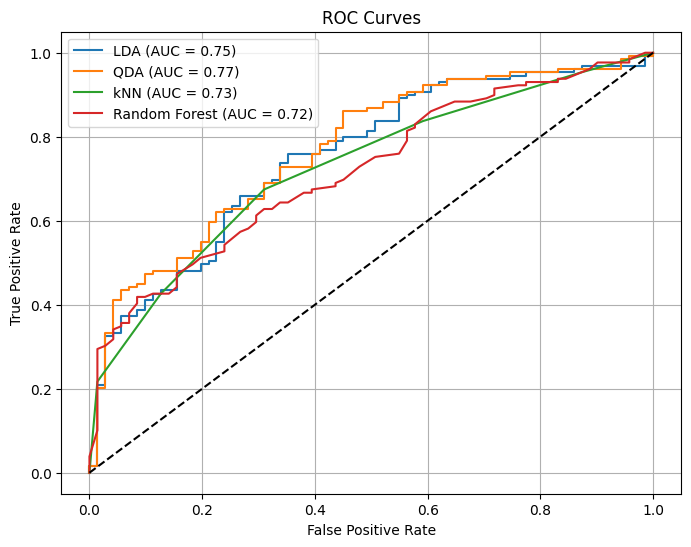

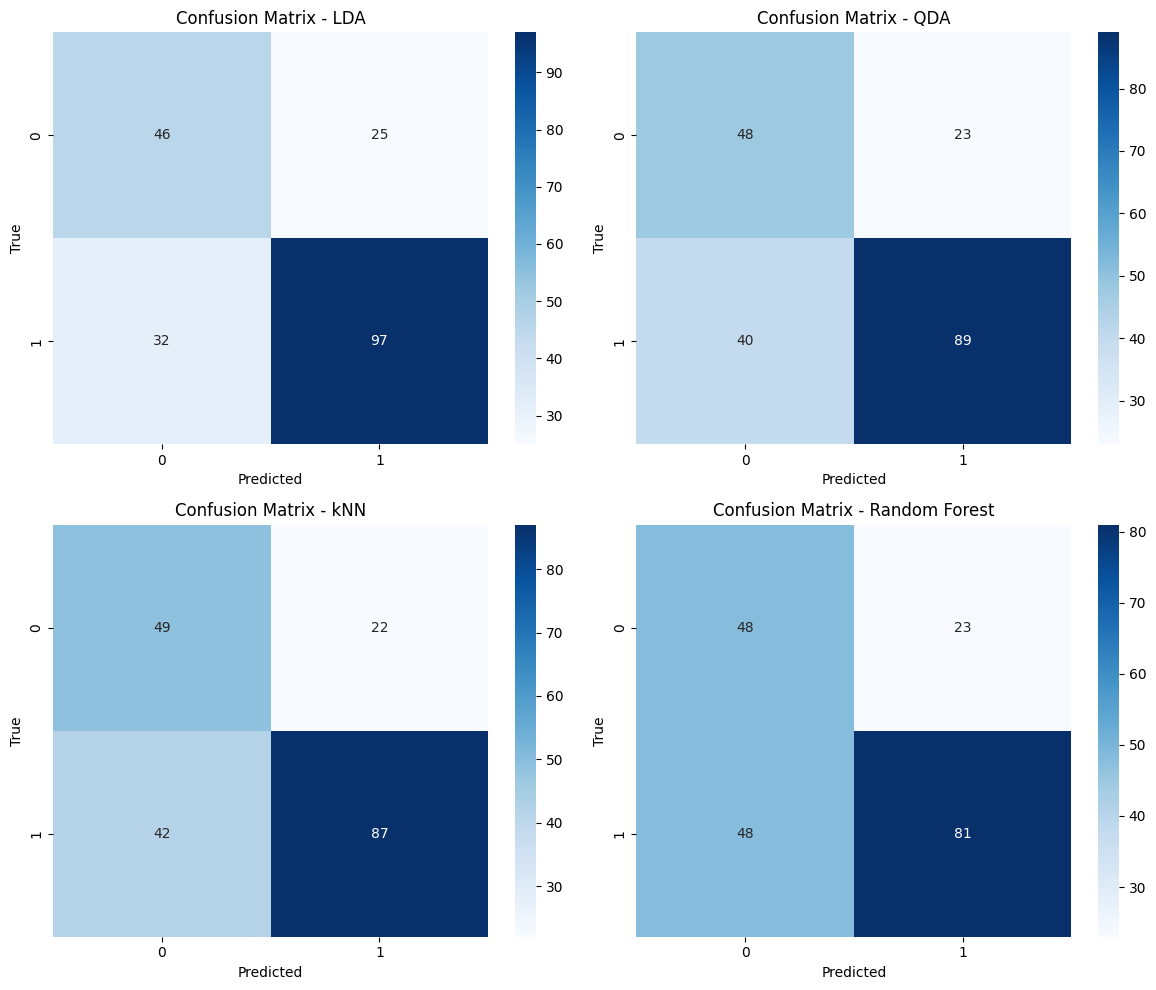


Model Comparison:
           Model  Test Accuracy   ROC AUC
0            LDA          0.715  0.752593
1            QDA          0.685  0.769298
2            kNN          0.680  0.727481
3  Random Forest          0.645  0.718364


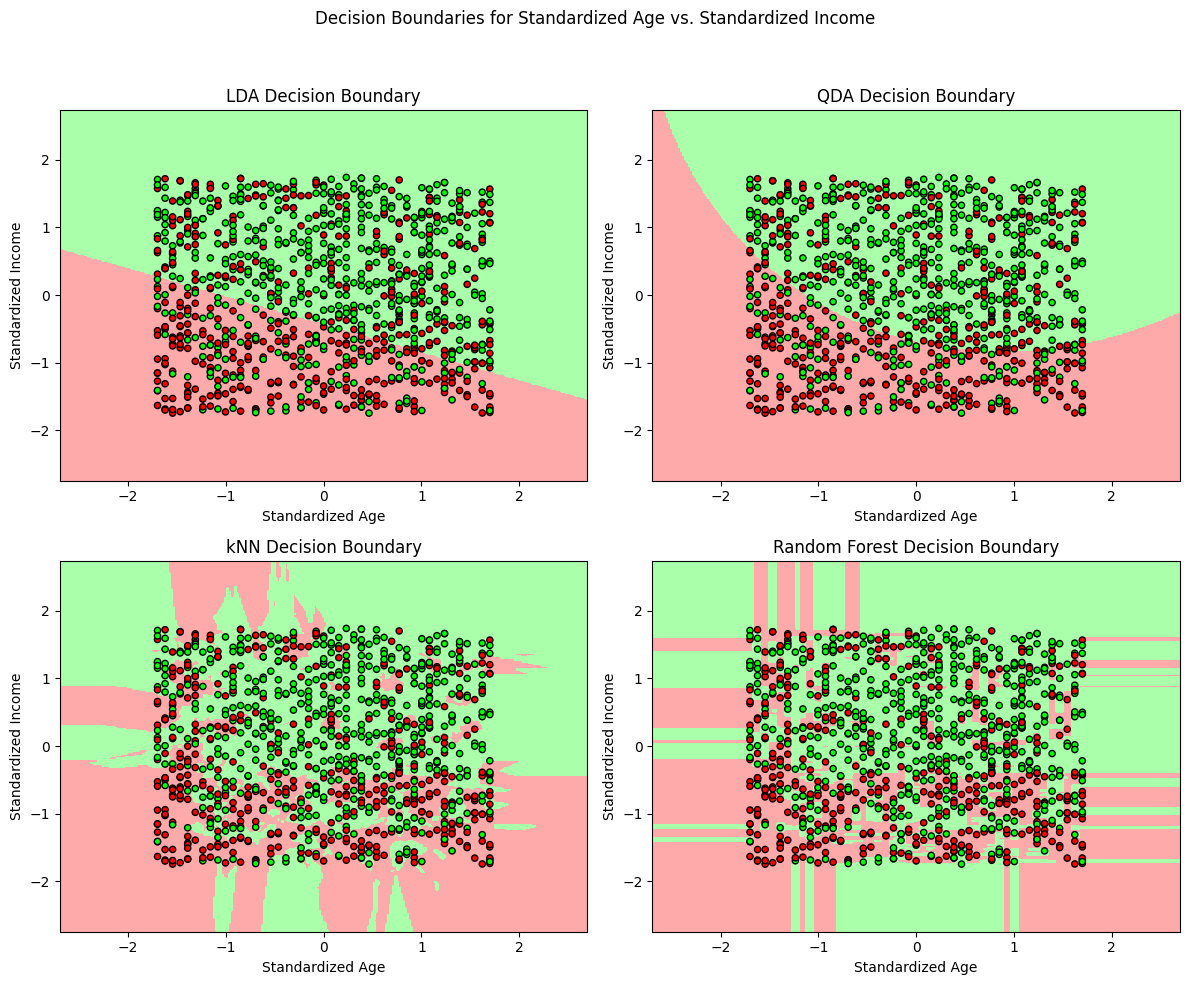

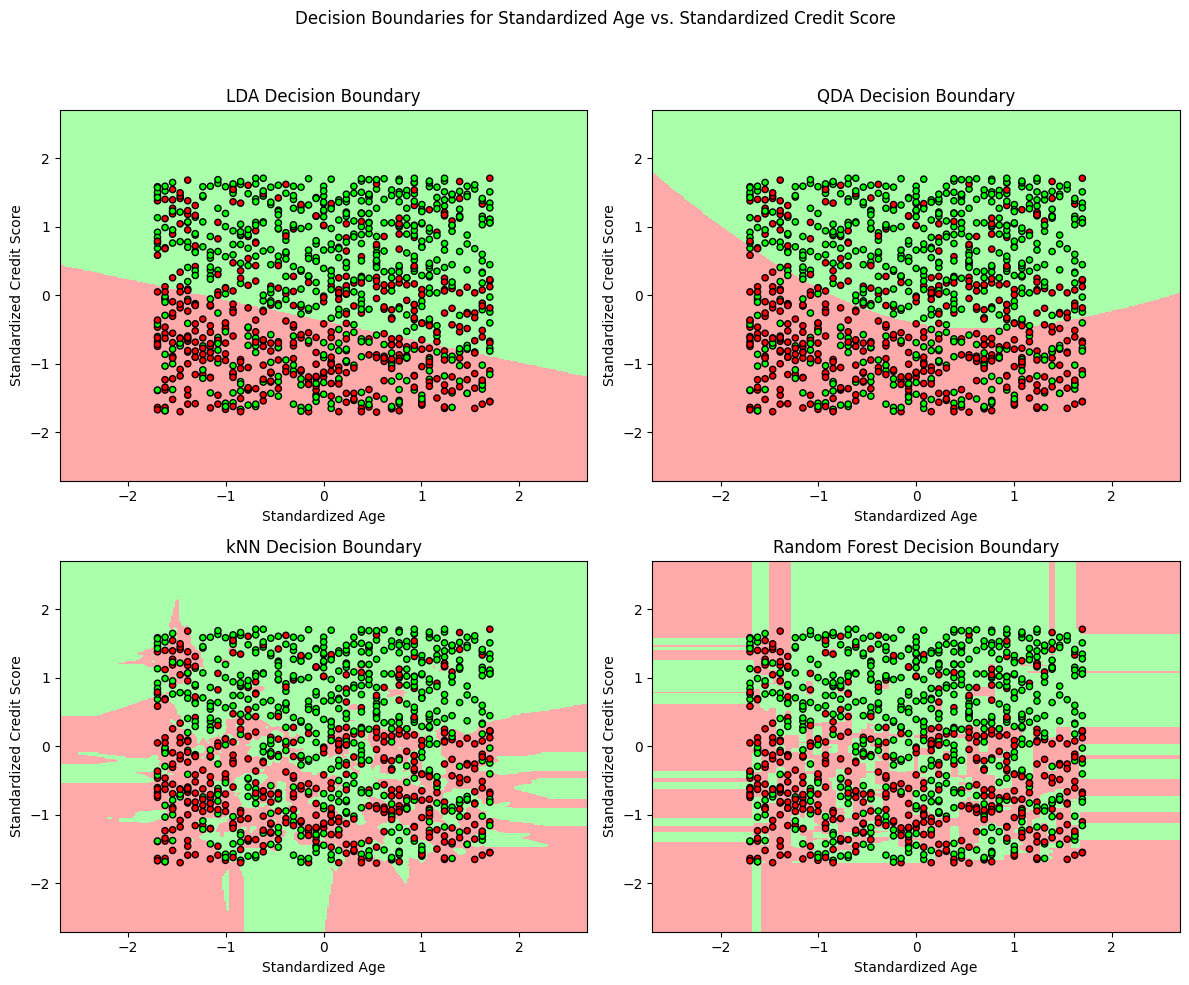

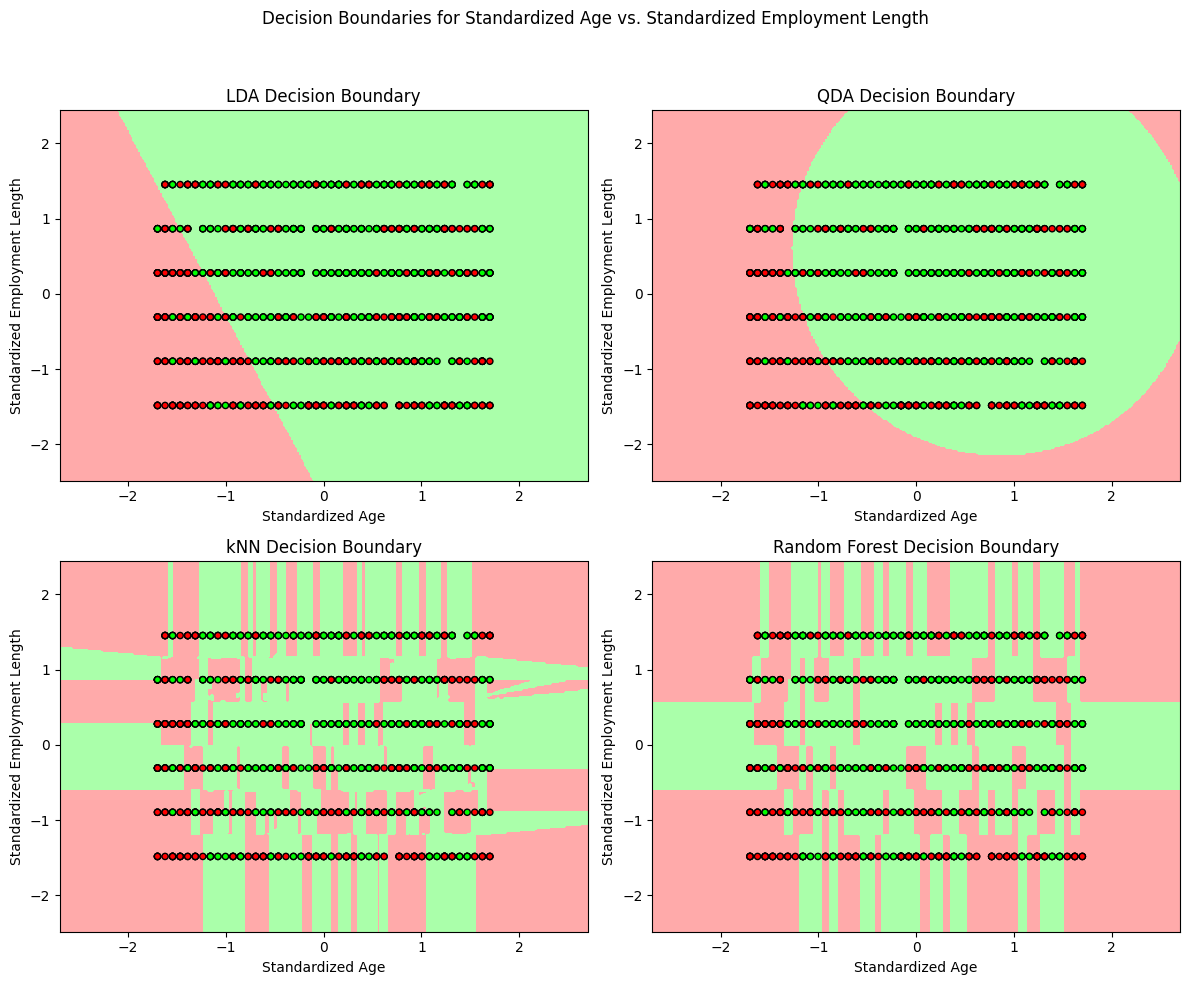

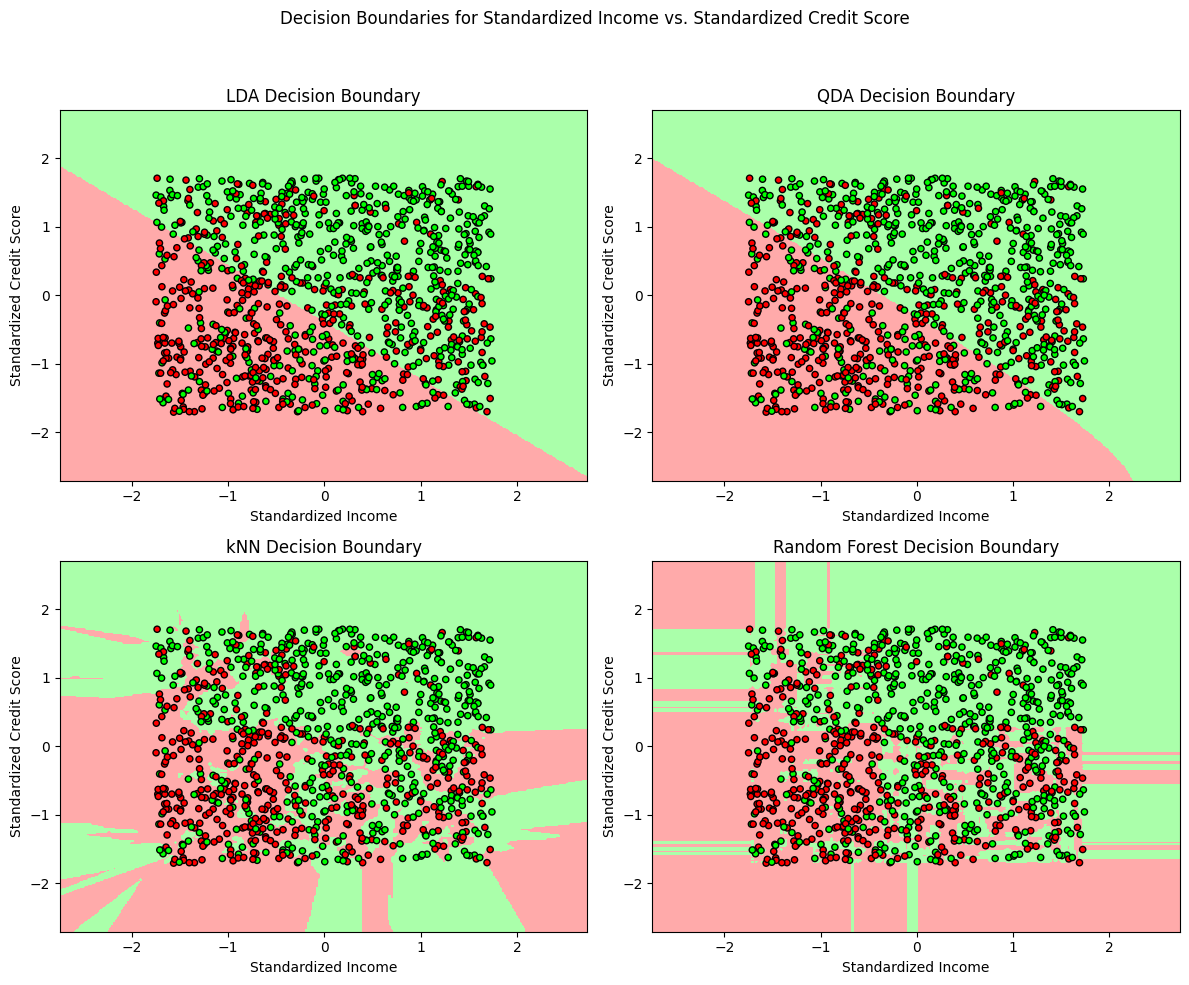

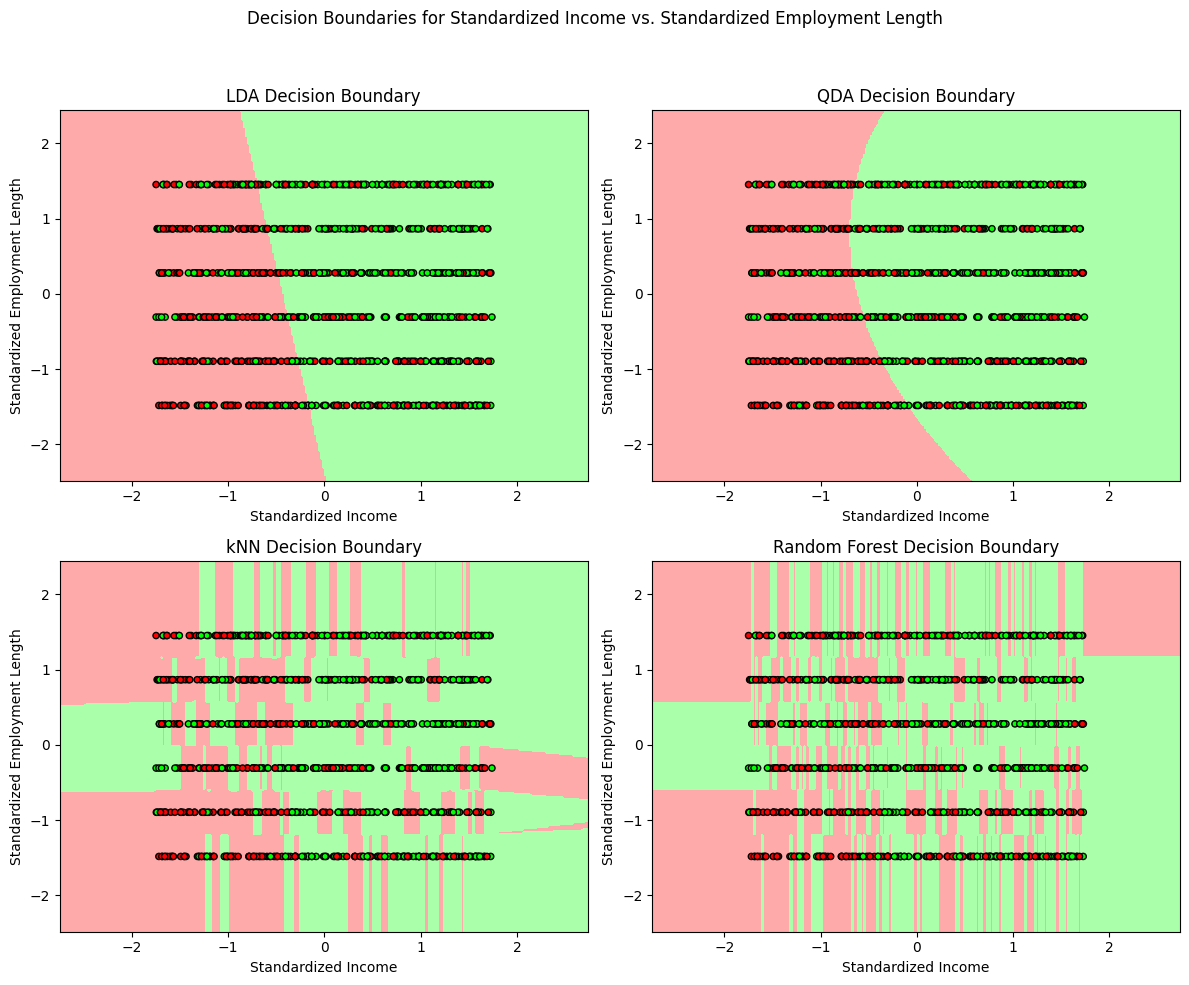

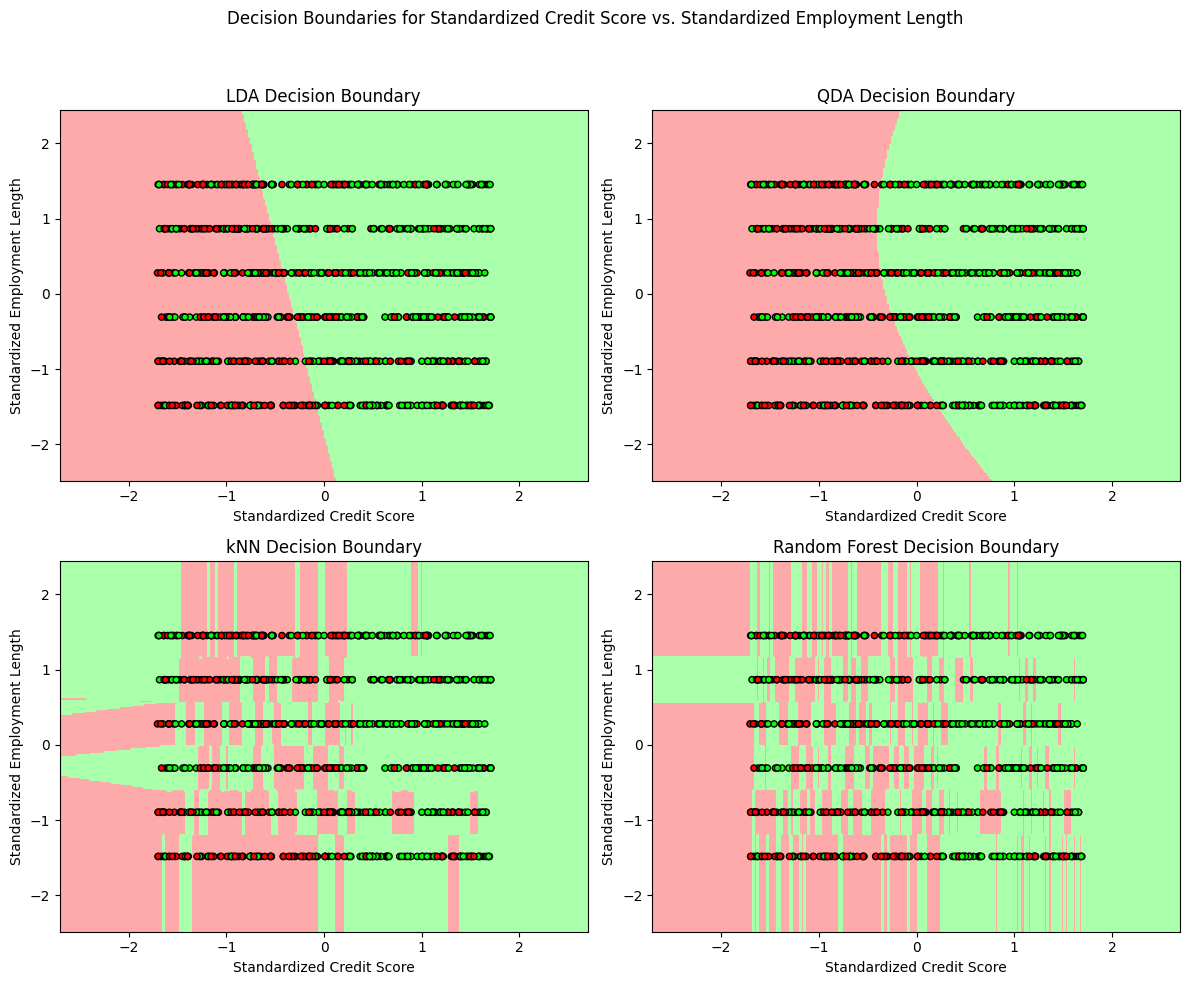

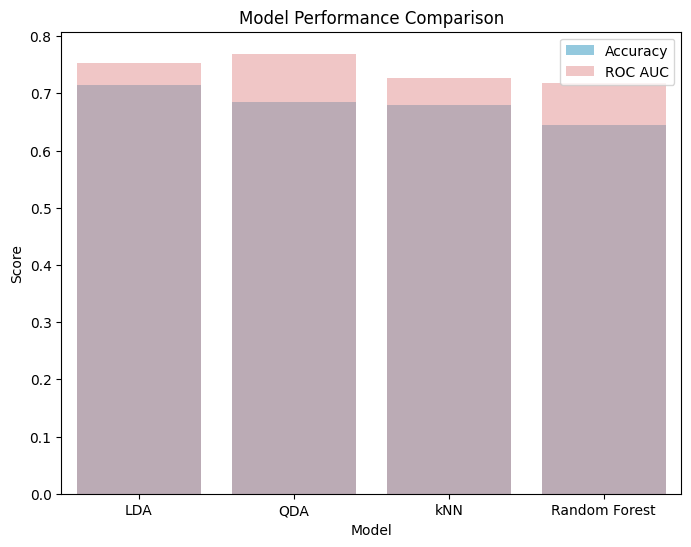

In [1]:
"""
decision_boundaries_analysis_feature_pairs.py

This script performs a classification analysis on a synthetic loan approval dataset, comparing
Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), K-Nearest Neighbors (kNN),
and Random Forest Classifier. It generates decision boundary plots for all pairs of features
(age, income, credit_score, employment_length) with loan_approved as the target variable.
The analysis includes classification reports, cross-validation scores, ROC curves, confusion matrices,
and a model comparison summary.

The dataset is synthetic, mimicking the "In Class Exercise.ipynb" with 1000 samples and imbalanced classes.
Features are standardized, and models are evaluated on a test set (20% of data).

Author: [Jesun Ushno]
Date: June 5, 2025
License: MIT
Dependencies: numpy, pandas, scikit-learn, matplotlib, seaborn
"""

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import itertools


def generate_synthetic_data(n_samples=1000, random_seed=42):
    """
    Generate a synthetic dataset for loan approval classification.

    Parameters:
    -----------
    n_samples : int, optional (default=1000)
        Number of samples to generate.
    random_seed : int, optional (default=42)
        Random seed for reproducibility.

    Returns:
    --------
    pd.DataFrame
        DataFrame containing features (age, income, credit_score, employment_length)
        and target (loan_approved).
    """
    np.random.seed(random_seed)

    # Generate features
    age = np.random.randint(20, 65, size=n_samples)
    income = np.random.randint(10000, 100000, size=n_samples)
    credit_score = np.random.randint(400, 900, size=n_samples)
    employment_length = np.random.randint(1, 7, size=n_samples)

    # Define target variable based on probabilistic rules
    def create_target(age, income, credit_score, employment_length):
        probability = (
            0.4 * (credit_score > 700) +
            0.3 * (income > 45000) +
            0.2 * (age > 25) +
            0.1 * (employment_length > 2)
        )
        return np.random.binomial(1, probability)

    target = [create_target(a, i, c, e) for a, i, c, e in
              zip(age, income, credit_score, employment_length)]

    # Create DataFrame
    return pd.DataFrame({
        'age': age,
        'income': income,
        'credit_score': credit_score,
        'employment_length': employment_length,
        'loan_approved': target
    })


def plot_decision_boundaries(X, y, models, feature_indices, feature_names):
    """
    Plot decision boundaries for the given models using two features.

    Parameters:
    -----------
    X : np.ndarray
        Scaled feature matrix.
    y : np.ndarray
        Target variable (loan_approved).
    models : dict
        Dictionary of model names and their instances.
    feature_indices : tuple
        Indices of the two features to plot.
    feature_names : list
        Names of the two features for axis labels.
    """
    # Select two features for 2D visualization
    X_2d = X[:, feature_indices]

    # Create mesh grid for decisionDeploy boundary
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    # Define color maps for visualization
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])  # Background colors
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])   # Data point colors

    # Set up subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for idx, (name, model) in enumerate(models.items()):
        # Train model on selected features
        model.fit(X_2d, y)

        # Predict over mesh grid
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot decision boundary and data points
        axes[idx].contourf(xx, yy, Z, cmap=cmap_light)
        axes[idx].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap=cmap_bold, edgecolors='black', s=20)
        axes[idx].set_title(f'{name} Decision Boundary')
        axes[idx].set_xlabel(feature_names[0])
        axes[idx].set_ylabel(feature_names[1])
        axes[idx].set_xlim(xx.min(), xx.max())
        axes[idx].set_ylim(yy.min(), yy.max())

    plt.suptitle(f'Decision Boundaries for {feature_names[0]} vs. {feature_names[1]}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def main():
    """Main function to execute the classification analysis and visualization."""
    # Generate and preprocess data
    data = generate_synthetic_data()
    X = data.drop('loan_approved', axis=1)
    y = data['loan_approved']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # Initialize models
    models = {
        'LDA': LinearDiscriminantAnalysis(),
        'QDA': QuadraticDiscriminantAnalysis(),
        'kNN': KNeighborsClassifier(n_neighbors=5),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }

    # Store results for analysis
    results = {
        'model': [],
        'accuracy': [],
        'roc_auc': [],
        'y_pred': {},
        'y_prob': {}
    }

    # Train and evaluate models
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_prob = (model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba')
                  else model.decision_function(X_test))

        # Store results
        results['model'].append(name)
        results['y_pred'][name] = y_pred
        results['y_prob'][name] = y_prob
        results['accuracy'].append(model.score(X_test, y_test))

        # Print classification report
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_test, y_pred))

        # Perform cross-validation
        cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
        print(f"\nCross-validation scores for {name}:")
        print(f"Mean CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

        # Compute and plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results['roc_auc'].append(roc_auc)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Finalize ROC plot
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Plot confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    for idx, (name, model) in enumerate(models.items()):
        cm = confusion_matrix(y_test, results['y_pred'][name])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
        axes[idx].set_title(f'Confusion Matrix - {name}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')
    plt.tight_layout()
    plt.show()

    # Display model comparison
    results_df = pd.DataFrame({
        'Model': results['model'],
        'Test Accuracy': results['accuracy'],
        'ROC AUC': results['roc_auc']
    })
    print("\nModel Comparison:")
    print(results_df)

    # Plot decision boundaries for all feature pairs
    feature_names = ['Standardized Age', 'Standardized Income',
                     'Standardized Credit Score', 'Standardized Employment Length']
    feature_indices = [(i, j) for i, j in itertools.combinations(range(4), 2)]

    for indices in feature_indices:
        names = [feature_names[i] for i in indices]
        plot_decision_boundaries(X_scaled, y, models, indices, names)

    # Plot model performance comparison
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Model', y='Test Accuracy', data=results_df, color='skyblue', label='Accuracy')
    sns.barplot(x='Model', y='ROC AUC', data=results_df, color='lightcoral', label='ROC AUC', alpha=0.5)
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()